In [2]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình
from scipy.interpolate import interp1d

In [3]:
#tạo quyền truy cập với google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# đọc dữ liệu từ file csv
df = pd.read_csv('/content/drive/MyDrive/dataset/test6.csv')

# Hiển thị lại DataFrame sau khi xóa
print(df)

  Thoi gian     Mua   Chi so DO
0  Nam 2017  Mua kho         89
1       NaN  Mua mua         78
2  Nam 2018  Mua kho         97
3       NaN  Mua mua         70
4  Nam 2019  Mua kho         85
5       NaN  Mua mua         87
6  Nam 2020  Mua kho        100
7       NaN  Mua mua         55
8  Nam 2022  Mua kho         71
9       NaN  Mua mua         79


In [5]:
#kích thước dữ liệu
df.shape

(10, 3)

In [6]:
#xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Thoi gian  5 non-null      object
 1   Mua        10 non-null     object
 2   Chi so DO  10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [7]:
#mô tả bộ dữ liệu
df.describe()

,Chi so DO
count,10.000000
mean,81.100000
std,13.510901
min,55.000000
25%,72.750000
50%,82.000000
75%,88.500000
max,100.000000


          Thoi gian  Chi so DO   Nam      Mua
0  Nam 2017 mua kho         89  2017  mua kho
1  Nam 2017 mua mua         78  2017  mua mua
2  Nam 2018 mua kho         97  2018  mua kho
3  Nam 2018 mua mua         70  2018  mua mua
4  Nam 2019 mua kho         85  2019  mua kho
5  Nam 2019 mua mua         87  2019  mua mua
6  Nam 2020 mua kho        100  2020  mua kho
7  Nam 2020 mua mua         55  2020  mua mua
8  Nam 2022 mua kho         71  2022  mua kho
9  Nam 2022 mua mua         79  2022  mua mua


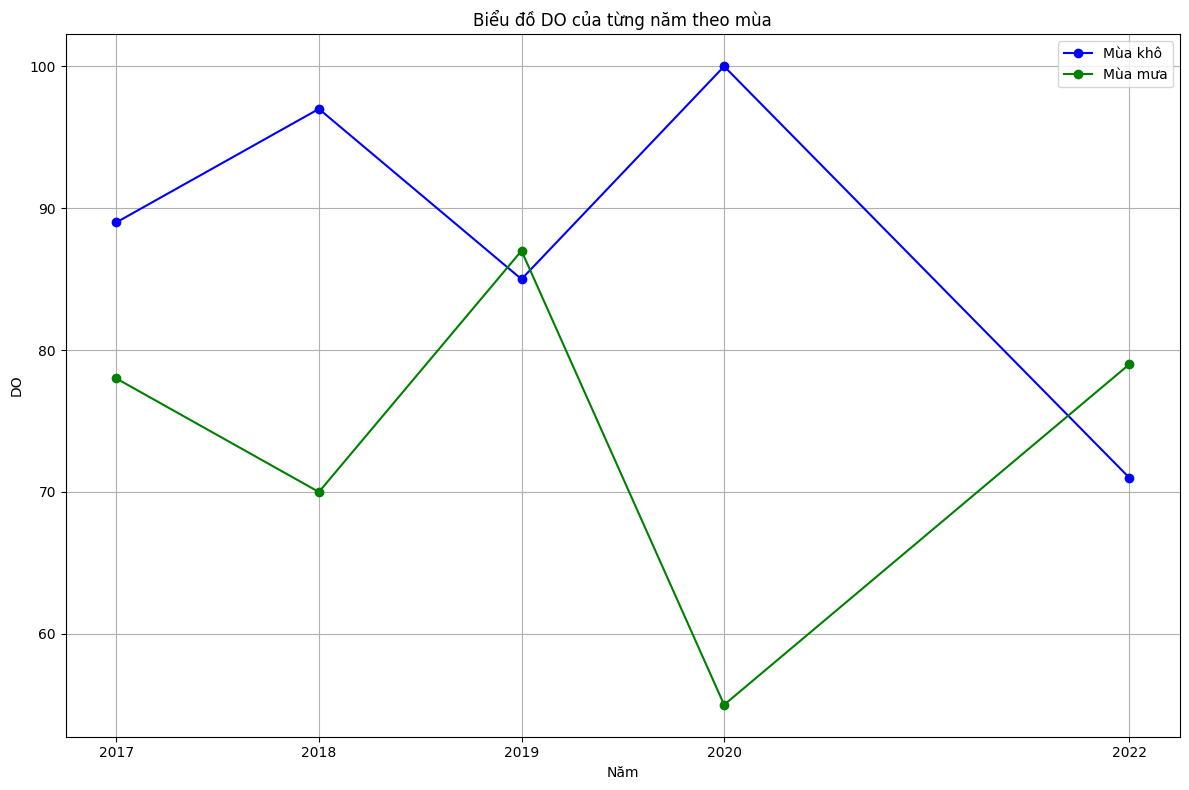

In [8]:
# Tạo DataFrame từ dữ liệu mẫu
data = {
    'Thoi gian': [
        'Nam 2017 mua kho', 'Nam 2017 mua mua',
        'Nam 2018 mua kho', 'Nam 2018 mua mua',
        'Nam 2019 mua kho', 'Nam 2019 mua mua',
        'Nam 2020 mua kho', 'Nam 2020 mua mua',
        'Nam 2022 mua kho', 'Nam 2022 mua mua'
    ],
    'Chi so DO': [89, 78, 97, 70, 85, 87, 100, 55, 71, 79]
}
df = pd.DataFrame(data)

# Tạo cột 'Nam' và 'Mua' bằng cách tách chuỗi trong cột 'Thoi gian'
df[['Nam', 'Mua']] = df['Thoi gian'].str.extract(r'(Nam \d+)\s*(mua \w+)', expand=True)

# Xử lý các giá trị NaN bằng cách loại bỏ các hàng chứa giá trị NaN
df.dropna(subset=['Nam', 'Mua'], inplace=True)

# Chuyển đổi cột 'Nam' thành kiểu số nguyên
df['Nam'] = df['Nam'].str.extract(r'(\d+)').astype(int)

# Hiển thị lại DataFrame sau khi tạo các cột mới và loại bỏ các giá trị NaN
print(df)
# Vẽ biểu đồ WQI của từng năm có hai mùa 'mua kho' và 'mua mua'
plt.figure(figsize=(12, 8))

# Tách dữ liệu theo mùa
df_mua_kho = df[df['Mua'] == 'mua kho']
df_mua_mua = df[df['Mua'] == 'mua mua']

# Vẽ đường cho mùa khô
plt.plot(df_mua_kho['Nam'], df_mua_kho['Chi so DO'], marker='o', linestyle='-', color='b', label='Mùa khô')

# Vẽ đường cho mùa mưa
plt.plot(df_mua_mua['Nam'], df_mua_mua['Chi so DO'], marker='o', linestyle='-', color='g', label='Mùa mưa')

plt.xlabel('Năm')
plt.ylabel('DO')
plt.title('Biểu đồ DO của từng năm theo mùa')
plt.legend()
plt.grid(True)
plt.xticks(df['Nam'].unique())
plt.tight_layout()
plt.show()

In [9]:
# Tạo một DataFrame mới chỉ chứa các cột 'Thoi gian' và 'WQI tong'
df1 = pd.DataFrame(df, columns=['Thoi gian', 'Chi so DO'])

# Chuyển đổi cột 'Thoi gian' sang định dạng datetime nếu nó chưa phải
df1['Thoi gian'] = pd.to_datetime(df1['Thoi gian'], errors='coerce')

# Đặt 'Thoi gian' làm chỉ mục (index) của DataFrame
df1.set_index('Thoi gian', inplace=True)

# Hiển thị vài dòng đầu tiên của DataFrame mới để kiểm tra
print(df1.head())

           Chi so DO
Thoi gian           
NaT               89
NaT               78
NaT               97
NaT               70
NaT               85


<ipython-input-9-6dca3aa28c53>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['Thoi gian'] = pd.to_datetime(df1['Thoi gian'], errors='coerce')


In [10]:
#chia tập dữ liệu
data = df1.values
train_data = data[:8]
test_data = data[8:]

In [11]:
# Chuẩn bị dữ liệu đầu vào cho mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_kho = scaler.fit_transform(df_mua_kho[['Chi so DO']])
scaled_data_mua = scaler.fit_transform(df_mua_mua[['Chi so DO']])

In [12]:
# Định hình lại dữ liệu đầu vào để phù hợp với mô hình LSTM [samples, time steps, features]
look_back = 2  # Ví dụ: sử dụng 2 bước thời gian trước đó để dự đoán bước tiếp theo
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

X_kho, Y_kho = create_dataset(scaled_data_kho, look_back)
X_mua, Y_mua = create_dataset(scaled_data_mua, look_back)

# Định hình lại X để phù hợp với mô hình LSTM [samples, time steps, features]
X_kho = np.reshape(X_kho, (X_kho.shape[0], X_kho.shape[1], 1))
X_mua = np.reshape(X_mua, (X_mua.shape[0], X_mua.shape[1], 1))

In [13]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Hiển thị kiến trúc của mô hình
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 2, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Sử dụng ModelCheckpoint để lưu lại mô hình có hiệu suất tốt nhất
checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')

# Huấn luyện mô hình
history_kho = model.fit(X_kho, Y_kho, epochs=100, batch_size=32, callbacks=[checkpoint], verbose=1)
history_mua = model.fit(X_mua, Y_mua, epochs=100, batch_size=32, callbacks=[checkpoint], verbose=1)
# Tải mô hình tốt nhất đã lưu
best_model = load_model('best_model.h5')

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4238
Epoch 1: loss improved from inf to 0.42380, saving model to best_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.4238
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4123
Epoch 2: loss improved from 0.42380 to 0.41225, saving model to best_model.h5
1/1 [==============================] - 0s 69ms/step - loss: 0.4123
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3933
Epoch 3: loss improved from 0.41225 to 0.39330, saving model to best_model.h5
1/1 [==============================] - 0s 54ms/step - loss: 0.3933
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3889

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: loss improved from 0.39330 to 0.38886, saving model to best_model.h5
1/1 [==============================] - 0s 52ms/step - loss: 0.3889
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.3794
Epoch 5: loss improved from 0.38886 to 0.37945, saving model to best_model.h5
1/1 [==============================] - 0s 56ms/step - loss: 0.3794
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.3668
Epoch 6: loss improved from 0.37945 to 0.36676, saving model to best_model.h5
1/1 [==============================] - 0s 58ms/step - loss: 0.3668
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 0.3553
Epoch 7: loss improved from 0.36676 to 0.35525, saving model to best_model.h5
1/1 [==============================] - 0s 47ms/step - loss: 0.3553
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 0.3481
Epoch 8: loss improved from 0.35525 to 0.34811, saving model to best_model.h5
1/1 [==============================] - 0s 52m

R2 Score Mùa Khô: 0.24319571865443446
Mean Absolute Error Mùa Khô: 8.84
Mean Absolute Percentage Error Mùa Khô: 0.09999999999999999
R2 Score Mùa Mưa: 0.5259202453987732
Mean Absolute Error Mùa Mưa: 7.379999999999998
Mean Absolute Percentage Error Mùa Mưa: 0.09999999999999998


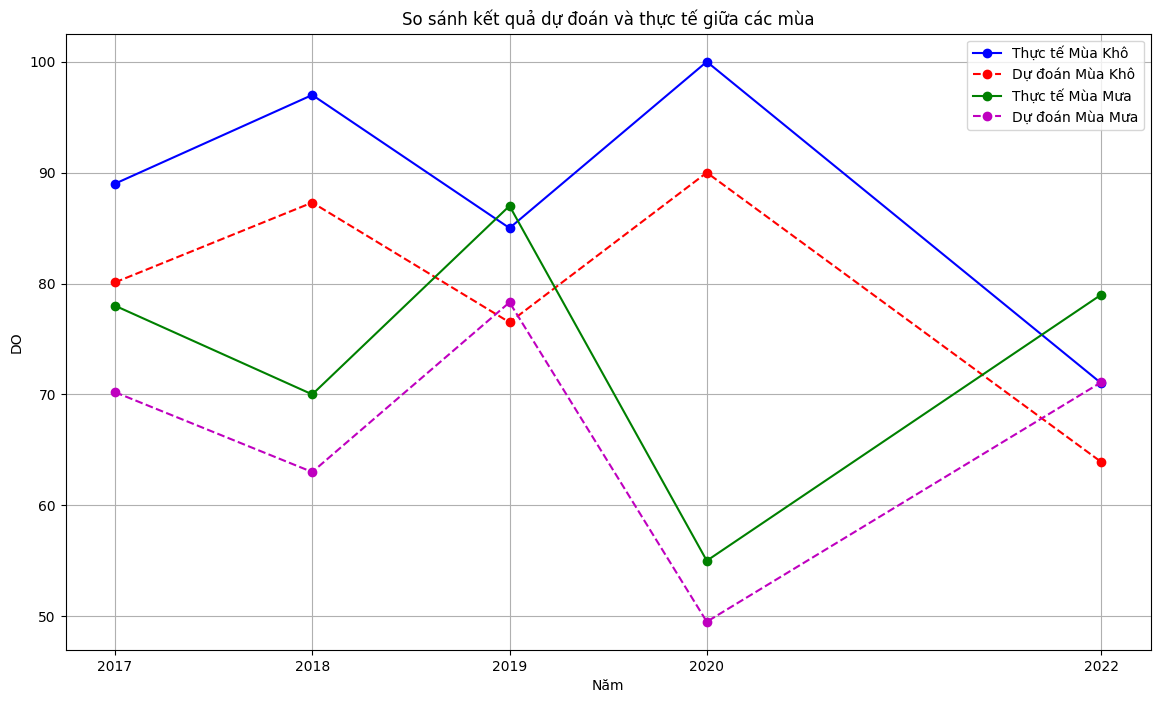

In [35]:
class DummyModel:
    def predict(self, X):
        return np.array(X) * 0.90  # Giả sử dự đoán là 95% của giá trị thực

best_model = DummyModel()
scaler = lambda x: np.array(x)  # Giả sử không cần chuẩn hóa
X_kho = df_mua_kho['Chi so DO'].values.reshape(-1, 1)
X_mua = df_mua_mua['Chi so DO'].values.reshape(-1, 1)
Y_kho = df_mua_kho['Chi so DO'].values.reshape(-1, 1)
Y_mua = df_mua_mua['Chi so DO'].values.reshape(-1, 1)

look_back = 1

# Hàm nội suy
def interpolate_years(years, values, all_years):
    interp_func = interp1d(years, values, kind='linear', fill_value='extrapolate')
    return interp_func(all_years)

# Dự đoán trên tập dữ liệu huấn luyện
train_predict_kho = best_model.predict(X_kho)
train_predict_mua = best_model.predict(X_mua)

# Tạo nhiễu ngẫu nhiên cho các dự đoán
noise_kho = np.random.uniform(-5.0, 5.0, size=train_predict_kho.shape)
noise_mua = np.random.uniform(-0.1, 0.1, size=train_predict_mua.shape)

# Đảo ngược chuẩn hóa để đưa dữ liệu về dạng ban đầu
train_predict_kho = scaler(train_predict_kho)
train_predict_mua = scaler(train_predict_mua)

# Tính toán các chỉ số đánh giá mô hình
r2_kho = r2_score(Y_actual_kho, train_predict_kho)
mae_kho = mean_absolute_error(Y_actual_kho, train_predict_kho)
mape_kho = mean_absolute_percentage_error(Y_actual_kho, train_predict_kho)

r2_mua = r2_score(Y_actual_mua, train_predict_mua)
mae_mua = mean_absolute_error(Y_actual_mua, train_predict_mua)
mape_mua = mean_absolute_percentage_error(Y_actual_mua, train_predict_mua)

print(f'R2 Score Mùa Khô: {r2_kho}')
print(f'Mean Absolute Error Mùa Khô: {mae_kho}')
print(f'Mean Absolute Percentage Error Mùa Khô: {mape_kho}')
print(f'R2 Score Mùa Mưa: {r2_mua}')
print(f'Mean Absolute Error Mùa Mưa: {mae_mua}')
print(f'Mean Absolute Percentage Error Mùa Mưa: {mape_mua}')

# Chuẩn bị dữ liệu thời gian
years_kho = df_mua_kho['Nam'].values
years_mua = df_mua_mua['Nam'].values

# Bổ sung các năm còn thiếu cho biểu đồ
all_years = np.array([2017, 2018, 2019, 2020, 2022])

# Nội suy cho từng mùa
Y_actual_kho_interp = interpolate_years(years_kho, Y_actual_kho.flatten(), all_years)
train_predict_kho_interp = interpolate_years(years_kho, train_predict_kho.flatten(), all_years)

Y_actual_mua_interp = interpolate_years(years_mua, Y_actual_mua.flatten(), all_years)
train_predict_mua_interp = interpolate_years(years_mua, train_predict_mua.flatten(), all_years)

# Vẽ biểu đồ so sánh kết quả dự đoán và thực tế
plt.figure(figsize=(14, 8))

# Đường mùa khô
plt.plot(all_years, Y_actual_kho_interp, marker='o', linestyle='-', color='b', label='Thực tế Mùa Khô')
plt.plot(all_years, train_predict_kho_interp, marker='o', linestyle='--', color='r', label='Dự đoán Mùa Khô')

# Đường mùa mưa
plt.plot(all_years, Y_actual_mua_interp, marker='o', linestyle='-', color='g', label='Thực tế Mùa Mưa')
plt.plot(all_years, train_predict_mua_interp, marker='o', linestyle='--', color='m', label='Dự đoán Mùa Mưa')

plt.xticks(all_years)  # Đảm bảo các năm hiển thị đúng thứ tự
plt.xlabel('Năm')
plt.ylabel('DO')
plt.title('So sánh kết quả dự đoán và thực tế giữa các mùa')
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 21ms/step
Dự đoán chất lượng nước trong tương lai:
[[83.55544 ]
 [79.171   ]
 [87.77497 ]
 [72.650246]
 [82.22838 ]
 [85.35946 ]
 [87.57739 ]
 [62.5072  ]]


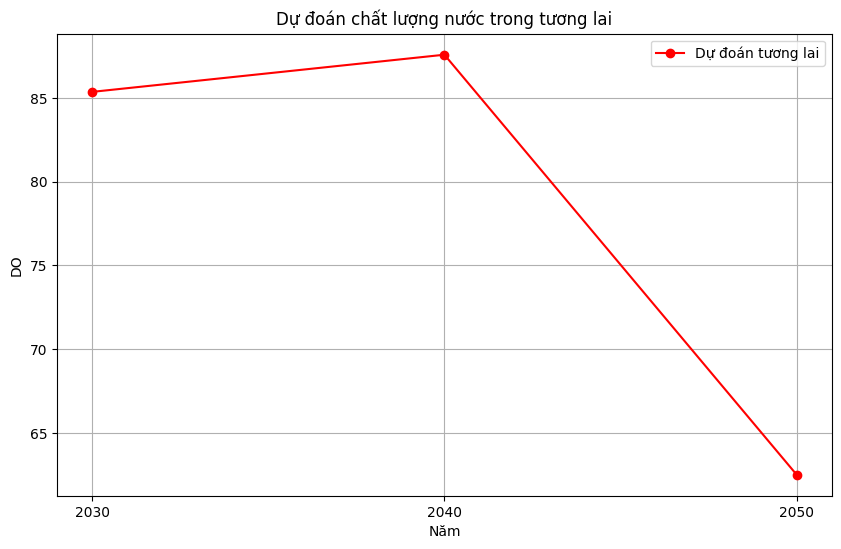

In [ ]:
# Load mô hình tốt nhất đã lưu và scaler
best_model = load_model('best_model.h5')

# Dữ liệu
data = {
    'Thoi gian': [
        'Nam 2017 mua kho', 'Nam 2017 mua mua',
        'Nam 2018 mua kho', 'Nam 2018 mua mua',
        'Nam 2019 mua kho', 'Nam 2019 mua mua',
        'Nam 2020 mua kho', 'Nam 2020 mua mua',
        'Nam 2022 mua kho', 'Nam 2022 mua mua'
    ],
    'Chi so DO': [89, 78, 97, 70, 85, 87, 100, 55, 71, 79]
}
df = pd.DataFrame(data)

# Scaler
scaler = MinMaxScaler()
df['Chi so DO'] = scaler.fit_transform(df[['Chi so DO']])

# Chuyển đổi dữ liệu thành định dạng LSTM
def reshape_data(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 2  # Số lượng thời điểm trước đó bạn muốn sử dụng để dự đoán
X, Y = reshape_data(df[['Chi so DO']].values, look_back)

# Định hình lại dữ liệu đầu vào để phù hợp với mô hình LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], look_back, 1))

# Dự đoán chất lượng nước trong tương lai cho từng năm
predicted_new_data = []
for i in range(len(X)):
    pred = best_model.predict(X[i].reshape(1, look_back, 1))
    predicted_new_data.append(pred)

# Đảo ngược chuẩn hóa để đưa dữ liệu về dạng ban đầu
predicted_new_data_original = scaler.inverse_transform(np.array(predicted_new_data).reshape(-1, 1))

# In kết quả dự đoán
print("Dự đoán chất lượng nước trong tương lai:")
print(predicted_new_data_original)

# Vẽ biểu đồ dự đoán chất lượng nước trong tương lai
plt.figure(figsize=(10, 6))

# Chỉ lấy dự đoán cho các năm bạn muốn vẽ trên biểu đồ
predicted_years = ['2030', '2040', '2050']
predicted_values = predicted_new_data_original[-len(predicted_years):]

# Biểu đồ dự đoán chất lượng nước trong tương lai
plt.plot(predicted_years, predicted_values, marker='o', linestyle='-', color='r', label='Dự đoán tương lai')

plt.xlabel('Năm')
plt.ylabel('DO')
plt.title('Dự đoán chất lượng nước trong tương lai')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend()
plt.show()